In [1]:
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

In [2]:
def ShowImage(images):
    fig= plt.figure(figsize=(10, 7))
    rows= 2; columns= 2
    for i,img in enumerate(images):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img, cmap="gray")

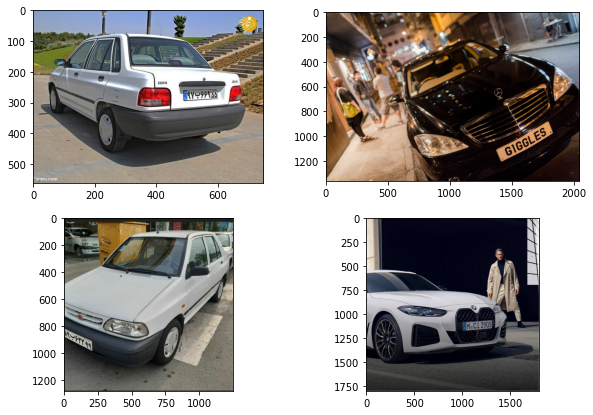

In [3]:
folder= 'yolov5/image/'
names= ['car3.jpg', 'car13.jpg', 'car4.jpg', 'car24.jpg']

images= []
for name in names:
    image = cv2.imread(folder+name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
ShowImage(images)

In [4]:
addr='yolov5/weights/licence-plate.pt'
model = torch.hub.load('./yolov5', 'custom', path=addr, source='local')  # local repo

/home/iran/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0
YOLOv5 🚀 v6.0-16-g6d9b99f torch 1.9.1+cu102 CPU

Fusing layers... 
Model Summary: 316 layers, 21472671 parameters, 0 gradients
Adding AutoShape... 


In [5]:
results= []
for img in images:
    res= model(img, size=640)  # includes NMS
    results.append(res)

In [6]:
rects=[]
for _, res in enumerate(results):
    rect=[]
    if res.xyxy[0].tolist():
        for PLT in res.xyxy[0].tolist():
            rect.append(list(map(int, PLT)))
    rects.append(rect)

In [7]:
# x,y,w,h,_,_= map(int, results.xyxy[0].tolist()[0])

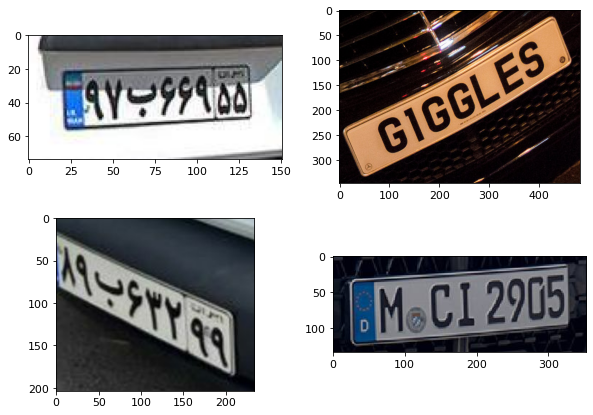

In [8]:
plates=[]
images_rect= []
for i, rect in enumerate(rects):
    img2=images[i].copy()
    for PLT in rect:
        x,y,w,h, _, _= PLT
        dic=20
        y= y-dic; h=h+dic; x=x-dic; w=w+dic;
        
        if y-dic<0: y=0
        if h-dic<0: h=0
        if w-dic<0: w=0
        if x-dic<0: x=0
        
        plate= img2[y:h, x:w]
        plates.append(plate)
        img=cv2.rectangle(img2.copy(),(x,y),(w,h),(0,255,0),5)
    images_rect.append(img)
    
del plates[2];
ShowImage(plates)

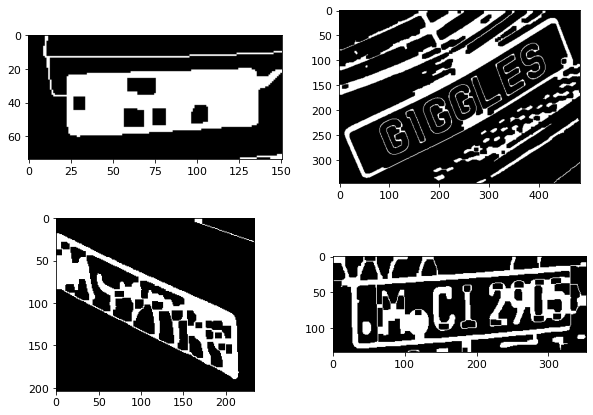

In [69]:
PlatesContours2=[]
ImagesEdged=[]
for xpl in plates:
    gray = cv2.cvtColor(xpl, cv2.COLOR_BGR2GRAY)
#     gray= cv2.equalizeHist(gray)
    clahe= cv2.createCLAHE(clipLimit=2.0,  tileGridSize=(8,8))
    gray= clahe.apply(gray)

    bilateral = cv2.bilateralFilter(gray, 11, 17, 17)
    blur = cv2.GaussianBlur(bilateral, (5, 5), 0)
    edged = cv2.Canny(blur, 50, 200)

    kernel = np.ones((3,3),np.uint8)
    kernel2 = np.ones((2,2),np.uint8)
    edged = cv2.dilate(edged, kernel, iterations = 3)
    edged = cv2.erode(edged, kernel2, iterations = 6)
#     edged = cv2.dilate(edged, kernel, iterations = 1)

    (contours, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

    PlatesContours2.append(contours)
    ImagesEdged.append(edged)

ShowImage(ImagesEdged)

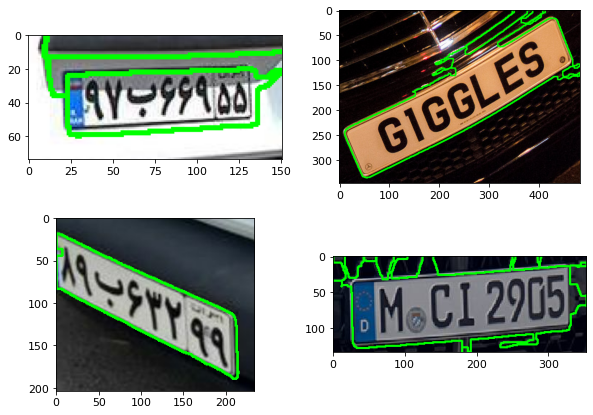

In [74]:
PlatesContours=[]
for _, contours in enumerate(PlatesContours2):
    rectangleContours = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approximationAccuracy = 0.2 * perimeter
        approximation = cv2.approxPolyDP(contour, approximationAccuracy, True)
    #     print(len(approximation))
        if len(approximation)>=2:
            rectangleContours.append(contour)
    PlatesContours.append(rectangleContours)
        
# print(len(rectangleContours))
# plateContour = rectangleContours

PlatesRect=[]
for i, plateContour in enumerate(PlatesContours):
    for plateContour in plateContour:
        xpl= cv2.drawContours(plates[i].copy(), [plateContour], -1, (0, 255, 0), 2)
    PlatesRect.append(xpl)
    
ShowImage(PlatesRect)


# Perspective

In [75]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [76]:
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

In [77]:
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

In [79]:
def transform(Plate, contours):
    approx = simplify_contour(contours[0], n_corners=4)
    x0, y0 = approx[0][0][0], approx[0][0][1]
    x1, y1 = approx[1][0][0], approx[1][0][1]
    x2, y2 = approx[2][0][0], approx[2][0][1]
    x3, y3 = approx[3][0][0], approx[3][0][1]

    points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
    points = np.array(points)
    crop_mask_img = four_point_transform(Plate, points)
    crop_mask_img= cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
    return crop_mask_img;

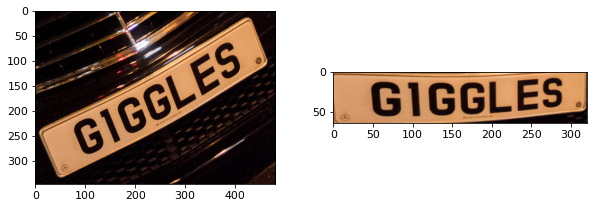

In [94]:
crop_mask_img= transform(plates[1], PlatesContours[1])
ShowImage([plates[1], crop_mask_img])

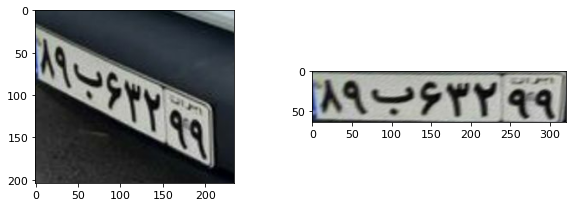

In [98]:
crop_mask_img= transform(plates[2], PlatesContours[2])
ShowImage([plates[2], crop_mask_img])

# My library Perspective

In [96]:
from PerspectivePlate import Perspective

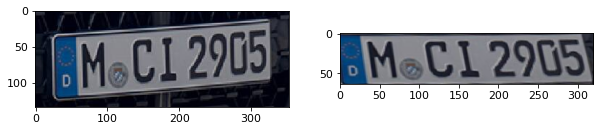

In [99]:
ShowImage([plates[3], Perspective(plates[3])])